In [86]:
from psycopg2 import connect, extras
from mouseBehavior import mouseBehaviorData as mbd
import numpy as np
import os, glob
from visual_behavior.visualization.extended_trials.daily import make_daily_figure
from visual_behavior.translator.core import create_extended_dataframe
from visual_behavior.translator.foraging2 import data_to_change_detection_core
from visual_behavior.ophys.sync import sync_dataset
import pandas as pd

### specify lims id for experiment to analyze

In [3]:
lims_ecephys_id = '1007083115'

#### connect to lims

In [5]:
con = connect(
            dbname='lims2',
            user='limsreader',
            host='limsdb2',
            password='limsro',
            port=5432,
        )
con.set_session(
            readonly=True, 
            autocommit=True,
        )
cursor = con.cursor(
            cursor_factory=extras.RealDictCursor,
        )
cursor = con.cursor(
            cursor_factory=extras.RealDictCursor,
        )

#### get storage directory for this experiment

In [65]:
QRY = '''
    SELECT 
        es.storage_directory,
        es.foraging_id,
        bs.storage_directory AS behavior_dir
    FROM ecephys_sessions es
        JOIN behavior_sessions bs ON bs.foraging_id = es.foraging_id
    WHERE es.id = {}
    '''

cursor.execute(QRY.format('1007083115'))
data_dir = cursor.fetchall()
print(data_dir[0])

RealDictRow([('storage_directory', '/allen/programs/braintv/production/visualbehavior/prod0/specimen_941629777/ecephys_session_1007083115/'), ('foraging_id', '02a7a8c500cd46c98d74ce3e7ab65dc9'), ('behavior_dir', '/allen/programs/braintv/production/visualbehavior/prod0/specimen_941629777/behavior_session_981982649/')])


In [125]:
ephys_dir = r'\\' + os.path.normpath(data_dir[0]['storage_directory'])[1:]
behavior_dir = r'\\' + os.path.normpath(data_dir[0]['behavior_dir'])[1:]

## Not sure why there are so many sub directories in the storage directory... get files from most recent
sub_dirs = [os.path.join(ephys_dir, d) for d in os.listdir(ephys_dir) if os.path.isdir(os.path.join(ephys_dir,d)) and not 'eye'in d]
mod_time = np.array([os.path.getmtime(d) for d in sub_dirs])
ephys_file_dir = sub_dirs[np.argmax(mod_time)]

In [85]:
SYNC_FILE = glob.glob(os.path.join(ephys_file_dir, '*.sync'))[0]
BEHAVIOR_PKL = glob.glob(os.path.join(behavior_dir, '*.pkl'))[0]
REPLAY_PKL = glob.glob(os.path.join(ephys_file_dir, '*.replay.pkl'))[0]
MAPPING_PKL = glob.glob(os.path.join(ephys_file_dir, '*.stim.pkl'))[0]

for f,s in zip([SYNC_FILE, BEHAVIOR_PKL, REPLAY_PKL, MAPPING_PKL], ['sync: ', 'behavior: ', 'replay: ', 'mapping: ']):
    print(s + f)

sync: \\allen\programs\braintv\production\visualbehavior\prod0\specimen_941629777\ecephys_session_1007083115\1007324811\1007083115_487460_20191113.sync
behavior: \\allen\programs\braintv\production\visualbehavior\prod0\specimen_941629777\behavior_session_981982649\02a7a8c500cd46c98d74ce3e7ab65dc9.pkl
replay: \\allen\programs\braintv\production\visualbehavior\prod0\specimen_941629777\ecephys_session_1007083115\1007324811\1007083115_487460_20191113.replay.pkl
mapping: \\allen\programs\braintv\production\visualbehavior\prod0\specimen_941629777\ecephys_session_1007083115\1007324811\1007083115_487460_20191113.stim.pkl


### plot behavior summary

<IPython.core.display.Javascript object>


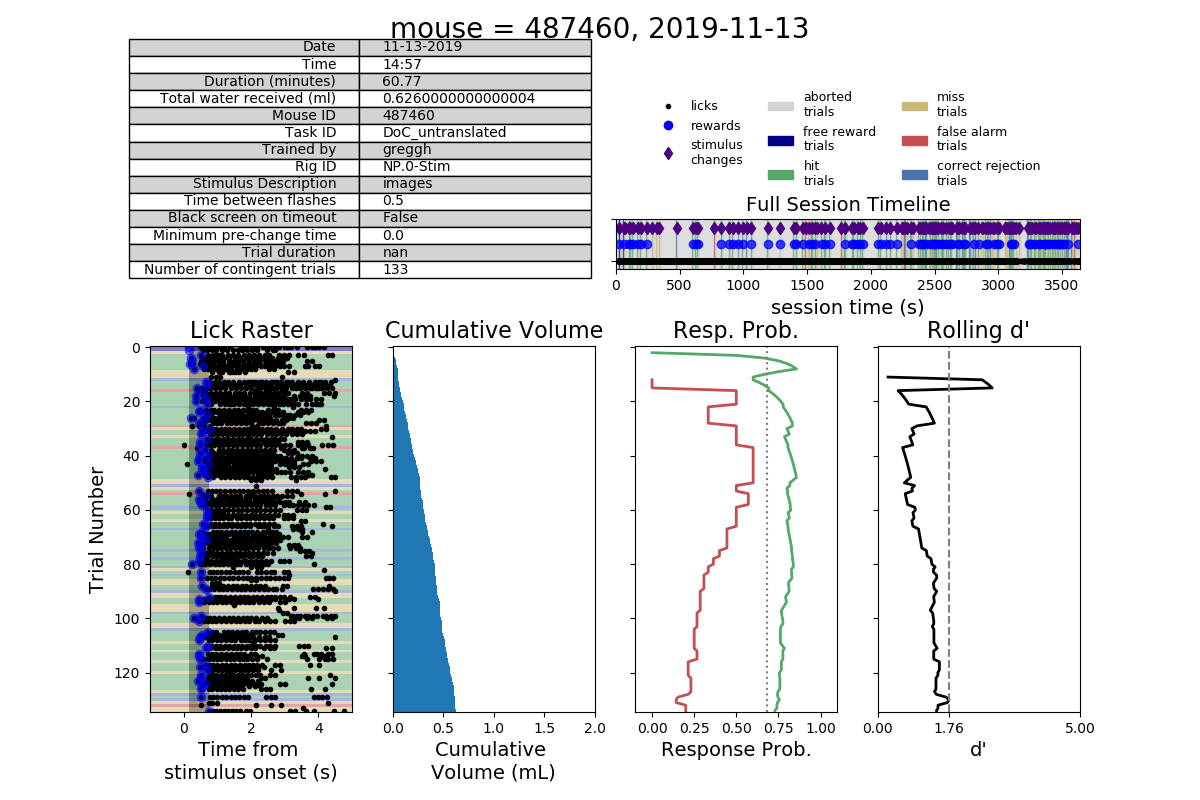

<IPython.core.display.Javascript object>


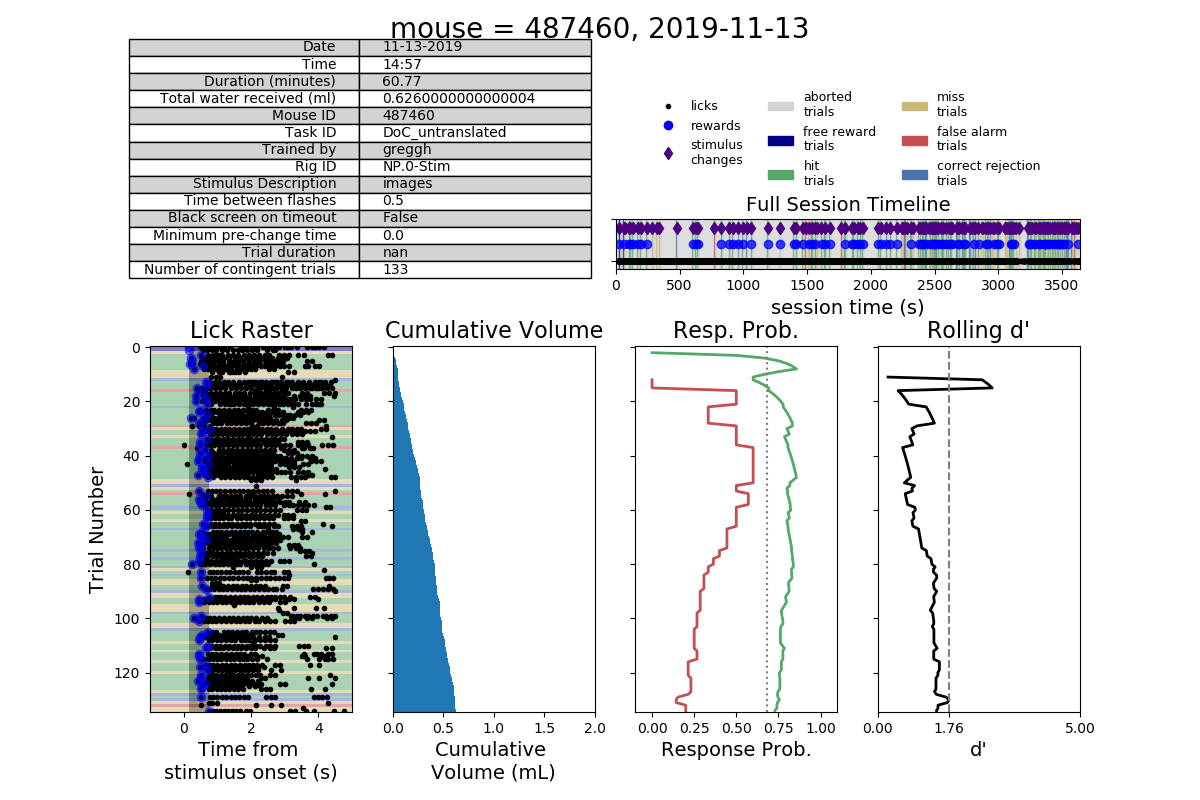

In [108]:
from matplotlib import pyplot as plt
%matplotlib notebook

behavior_data = pd.read_pickle(BEHAVIOR_PKL)
core_data = data_to_change_detection_core(behaviordata)
trials = create_extended_dataframe(
    trials=core_data['trials'],
    metadata=core_data['metadata'],
    licks=core_data['licks'],
    time=core_data['time'])

mapping_data = pd.read_pickle(MAPPING_PKL)
replay_data = pd.read_pickle(REPLAY_PKL)

make_daily_figure(trials)

### get sync data

In [87]:
def get_sync_line_data(syncDataset, line_label=None, channel=None):
    ''' Get rising and falling edge times for a particular line from the sync h5 file
        
        Parameters
        ----------
        dataset: sync file dataset generated by sync.Dataset
        line_label: string specifying which line to read, if that line was labelled during acquisition
        channel: integer specifying which channel to read in line wasn't labelled
        
        Returns
        ----------
        rising: npy array with rising edge times for specified line
        falling: falling edge times
    '''
    if isinstance(line_label, str):
        if line_label in syncDataset.line_labels:
            channel = syncDataset.line_labels.index(line_label)
        else:
            logging.warning('Invalid Line Label: ' + line_label)
            return
    elif channel is None:
        logging.warning('Must specify line label')
        return
    
    sample_freq = syncDataset.meta_data['ni_daq']['counter_output_freq']
    rising = syncDataset.get_rising_edges(channel)/sample_freq
    falling = syncDataset.get_falling_edges(channel)/sample_freq
    
    return rising, falling

syncDataset = sync_dataset.Dataset(SYNC_FILE)

c:\users\svc_ccg\appdata\local\continuum\anaconda3\envs\lims\lib\site-packages\visual_behavior-0.6.0.dev0-py2.7.egg\visual_behavior\ophys\sync\sync_dataset.py:119: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  self.meta_data = eval(self.dfile['meta'].value)
c:\users\svc_ccg\appdata\local\continuum\anaconda3\envs\lims\lib\site-packages\visual_behavior-0.6.0.dev0-py2.7.egg\visual_behavior\ophys\sync\sync_dataset.py:217: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return self.dfile['data'].value


#### plot vsync intervals

<IPython.core.display.Javascript object>


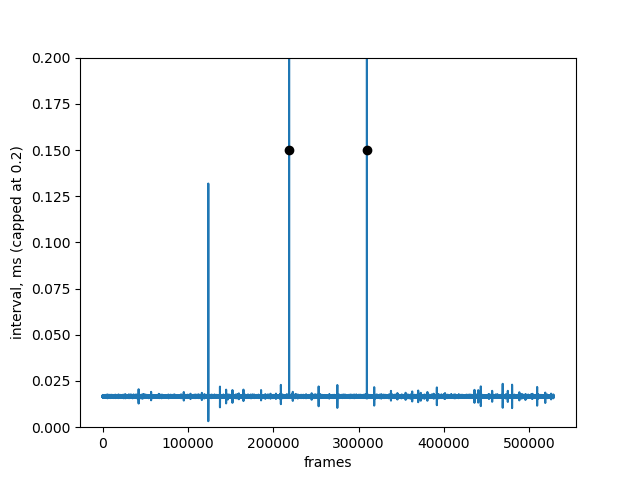

Text(0,0.5,u'interval, ms (capped at 0.2)')

In [126]:
vr, vf = get_sync_line_data(syncDataset, 'stim_vsync')

fig, ax = plt.subplots()
ax.plot(np.diff(vf))
ax.set_ylim([0, 0.2])

expected_break_1 = len(core_data['time'])
ax.plot(expected_break_1, 0.15, 'ko')

expected_break_2 = expected_break_1 + mapping_data['intervalsms'].size
ax.plot(expected_break_2, 0.15, 'ko')
ax.set_xlabel('frames')
ax.set_ylabel('interval, ms (capped at 0.2)')

In [124]:
total_pkl_frames = (behavior_data['items']['behavior']['intervalsms'].size +
                    mapping_data['intervalsms'].size +
                    replay_data['intervalsms'].size + 3) #Add 3 since these are all intervals

assert(total_pkl_frames == len(vf))

3